In [1]:
import math

import pandas as pd
from nltk.stem import PorterStemmer
from nltk import word_tokenize

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

import utils

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [13]:
stemmer = PorterStemmer()

In [10]:
tdf_g = pd.read_csv('speaker_grouped_trimmed.csv', index_col=0)

In [11]:
tdf_g

,date,speaker,text_enhanced
1696,1994-02-04,CHAIRMAN GREENSPAN.,"As you know, this is our organizational meetin..."
1697,1994-02-04,MR. BERNARD.,"Secretary and Economist, Donald Kohn; Deputy S..."
1698,1994-02-04,MR. BOEHNE.,"Normally in an economic expansion, development..."
1699,1994-02-04,MR. BROADDUS.,My report is going to be pretty bland after th...
1700,1994-02-04,MR. COYNE.,"Oh, believe me, you will get asked! I think i..."
...,...,...,...
6827,2017-12-13,MS. BRAINARD.,I don't think of this as a normative statement...
6828,2017-12-13,MS. GEORGE.,"Lorie, on exhibit 2, chart 12, would you expla..."
6829,2017-12-13,MS. LOGAN.,Thank you. I will begin on your second exhibi...
6830,2017-12-13,MS. MESTER.,"Thank you, Madam Chair. Reports received from..."


In [14]:
tdf_g['tokens'] = tdf_g['text_enhanced'].apply(lambda x : utils.process(x, stemmer=stemmer)) 

In [15]:
texts = tdf_g['tokens'].tolist()

In [16]:
dictionary = Dictionary(texts)

In [17]:
unfiltered_corpus = [dictionary.doc2bow(text) for text in texts]

In [18]:
len(dictionary)

28480

In [19]:
count = 0

freqs = {}
doc_appears = {}

for text in texts:
    for token, freq in dictionary.doc2bow(text):
        if token in freqs:
            freqs[token] += freq
        else:
            freqs[token] = freq
        if token in doc_appears:
            doc_appears[token] += 1
        else:
            doc_appears[token] = 1
    count +=1

In [20]:
idf = {i: math.log(len(texts) / doc_appears[i]) for i in range(len(dictionary))}

In [21]:
tfidf_global = {i: idf[i] * (1 + math.log(freqs[i])) for i in range(len(dictionary))}

In [22]:
tfidf_vals = sorted([rank for rank in tfidf_global.values()], reverse=True)

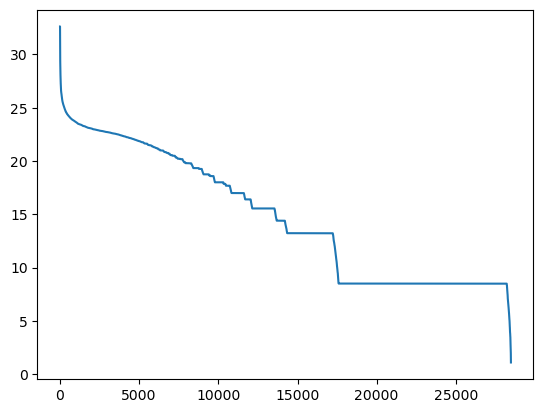

In [23]:
plt.plot(tfidf_vals)

In [24]:
tokens_to_keep = [i for i, tfidf in tfidf_global.items() if tfidf > tfidf_vals[13000]]
len(tokens_to_keep)

12141

In [25]:
dictionary.filter_tokens(good_ids=tokens_to_keep)
dictionary.compactify()
len(dictionary)

12141

In [26]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [27]:
K = 45

In [77]:
ldamodel = LdaModel(corpus, num_topics=K, id2word=dictionary, passes=10, random_state=0, minimum_probability=0, eta=0.025, alpha=50/K)

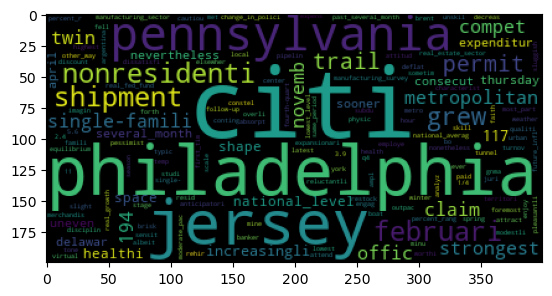

In [100]:
plt.imshow(WordCloud().fit_words(dict(ldamodel.show_topic(23, 200))))

In [115]:
ldamodel.print_topics(num_topics=45, num_words=10)

[(0,
  '0.063*"intervent" + 0.030*"neutral" + 0.014*"interven" + 0.010*"wind" + 0.010*"april" + 0.008*"point_increas" + 0.008*"steril" + 0.007*"counti" + 0.007*"basis_point_increas" + 0.006*"sometim"'),
 (1,
  '0.014*"c" + 0.011*"transitori" + 0.008*"2004" + 0.008*"portion" + 0.007*"warrant" + 0.007*"delay" + 0.006*"tension" + 0.006*"territori" + 0.005*"similarli" + 0.005*"mostli"'),
 (2,
  '0.042*"guidanc" + 0.024*"threshold" + 0.019*"bullard" + 0.018*"taper" + 0.013*"exit" + 0.011*"confer" + 0.010*"mandat" + 0.010*"principl" + 0.007*"efficaci" + 0.007*"framework"'),
 (3,
  '0.053*"facil" + 0.049*"overnight" + 0.031*"cap" + 0.025*"repo" + 0.022*"test" + 0.018*"counterparti" + 0.014*"quarter-end" + 0.013*"framework" + 0.012*"floor" + 0.011*"deposit"'),
 (4,
  '0.020*"2013." + 0.015*"fifth" + 0.008*"carolina" + 0.007*"sound" + 0.007*"virginia" + 0.007*"west" + 0.006*"obviou" + 0.006*"north" + 0.006*"paint" + 0.005*"complac"'),
 (5,
  '0.020*"relationship" + 0.019*"phillip" + 0.010*"expl

In [101]:
def get_all_topics(tokens):
    topic_probs = ldamodel[dictionary.doc2bow(tokens)]
    result = [0] * 45
    for topic, prob in topic_probs:
        result[topic] = prob
    return pd.Series(result)

In [102]:
tdf_g[[f'tprob_{i}' for i in range(45)]] = tdf_g.tokens.apply(get_all_topics)

In [103]:
tdf_g

,date,speaker,text_enhanced,tokens,tprob_0,tprob_1,tprob_2,tprob_3,tprob_4,tprob_5,...,tprob_35,tprob_36,tprob_37,tprob_38,tprob_39,tprob_40,tprob_41,tprob_42,tprob_43,tprob_44
1696,1994-02-04,CHAIRMAN GREENSPAN.,"As you know, this is our organizational meetin...","[know, organiz, meet, alway, meet, elect, chai...",0.004404,0.008949,0.002653,0.006702,0.002750,0.050188,...,0.004354,0.001986,0.011369,0.004209,0.002528,0.002396,0.006632,0.015304,0.009786,0.012351
1697,1994-02-04,MR. BERNARD.,"Secretary and Economist, Donald Kohn; Deputy S...","[secretari, economist, donald, kohn, deputi, s...",0.008159,0.007811,0.007978,0.008344,0.007726,0.032849,...,0.007895,0.008027,0.008027,0.008939,0.008031,0.010811,0.008585,0.007967,0.008053,0.195102
1698,1994-02-04,MR. BOEHNE.,"Normally in an economic expansion, development...","[normal, econom, expans, develop, real, sector...",0.029416,0.008627,0.010394,0.008996,0.014087,0.039934,...,0.051164,0.008765,0.016873,0.009061,0.009083,0.007732,0.014896,0.019493,0.013738,0.011027
1699,1994-02-04,MR. BROADDUS.,My report is going to be pretty bland after th...,"[report, go, pretti, bland, develop, sinc, dec...",0.022651,0.009844,0.010668,0.007975,0.065438,0.012191,...,0.043563,0.022021,0.054781,0.008207,0.009382,0.012754,0.028455,0.032175,0.034483,0.018991
1700,1994-02-04,MR. COYNE.,"Oh, believe me, you will get asked! I think i...","[oh, believ, get, ask, think, take, coupl, min...",0.021370,0.021370,0.022228,0.022331,0.021370,0.023363,...,0.022317,0.021370,0.021370,0.021938,0.021774,0.021370,0.022437,0.023204,0.021636,0.021370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6827,2017-12-13,MS. BRAINARD.,I don't think of this as a normative statement...,"[n't, think, norm, statement, think, forecast,...",0.012810,0.007640,0.029548,0.007228,0.005717,0.014820,...,0.019571,0.010681,0.023409,0.020669,0.006386,0.038567,0.006075,0.021845,0.068142,0.014719
6828,2017-12-13,MS. GEORGE.,"Lorie, on exhibit 2, chart 12, would you expla...","[lori, exhibit, 2, chart, 12, would, explain, ...",0.010186,0.023319,0.013816,0.014220,0.025812,0.019353,...,0.009778,0.009199,0.010526,0.008858,0.030778,0.015868,0.010058,0.012528,0.045103,0.008281
6829,2017-12-13,MS. LOGAN.,Thank you. I will begin on your second exhibi...,"[thank, begin, second, exhibit, discuss, money...",0.004748,0.005915,0.006965,0.133128,0.004600,0.010633,...,0.006902,0.008116,0.007262,0.006452,0.005348,0.010026,0.005117,0.006005,0.005974,0.004939
6830,2017-12-13,MS. MESTER.,"Thank you, Madam Chair. Reports received from...","[thank, madam, chair, report, receiv, contact,...",0.045581,0.014212,0.014528,0.005391,0.005924,0.007290,...,0.006382,0.006739,0.010212,0.015199,0.007071,0.274467,0.020371,0.013990,0.011407,0.009780


In [116]:
tdf_g.to_csv('grouped_w_topics.csv')